## Calculate (a) the sensitivity of the amplitude and phase of an oscillatory signal to (b) aquifer transmissivity and storativity parameters resulting from (c) a line-source forcing term

This Jupyter Notebook calculates the sensitivity of the amplitude and phase of an oscillatory signal to aquifer transmissivity and storativity parameters using the adjoint state-based solution derived by Cardiff and Barrash (2015). The Python code presented here is a direct translation of the original Matlab code, for which the copyright belongs to Michael Cardiff (University of Wisconsin-Madison), 2013-2014.

## First, define functions and parameters:

In [1]:
%matplotlib inline

# This Python script was translated from Matlab codes developed and provided as
# part of the following publication: Cardiff, M. and Barrash, W. (2015). 
# Analytical and semi-analytical tools for the design of oscillatory pumping 
# tests. Groundwater, 53(6), 896-907. The original Matlab codes are copyright
# of Michael Cardiff (University of Wisconsin-Madison), 2013-2014.

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.special import kv


# Define Black and Kipp (1981) solution
def phasor_linesrc_soln(Qpeak, om, S, T, xw, yw, x, y):
    return Qpeak/(2.*np.pi*T)*kv(0, ((om*((x-xw)**2.+(y-yw)**2.)*S)/T)**(0.5)*np.exp(1j*np.pi/4.))

    
def oscill_sens_generator_linesrc(Qpeak, period, S, T, domain_def, pump_loc, obs_loc):
    # Setup parameters needed to do the discretization and plotting
    om  = 2.*np.pi/period
    x_w = pump_loc[0]
    y_w = pump_loc[1]
    x_o = obs_loc[0]
    y_o = obs_loc[1]
    xmin  = domain_def[0,0]
    xstep = domain_def[0,1]
    xmax  = domain_def[0,2]
    ymin  = domain_def[1,0]
    ystep = domain_def[1,1]
    ymax  = domain_def[1,2]
    xv = np.arange(xmin, xmax, xstep)
    yv = np.arange(ymin, ymax, ystep)
    xg, yg = np.meshgrid(xv, yv)
    
    # Calculate the value of the phasor at the observation location
    # to be used in the source term for the phasor solution
    phasor_at_obs = phasor_linesrc_soln(Qpeak, om, S, T, x_w, y_w, x_o, y_o)
    obs_adjsrc_val = -1./phasor_at_obs
    
    # Calculate the phasor solution
    phasor_soln = phasor_linesrc_soln(Qpeak, om, S, T, x_w, y_w, xg, yg)
    
    # Calculate the adjoint solution
    adj_soln = phasor_linesrc_soln(obs_adjsrc_val, om, S, T, x_o, y_o, xg, yg)
    
    # Calculate sensitivity of metrics to ln(S). Note this is why the extra
    # the factor of S appears at the end of the sensitivity calculation
    logS_sens = phasor_soln*adj_soln*1j*om*S
    logmag_logS_sens = np.real(logS_sens)
    phase_logS_sens  = np.imag(logS_sens)
    
    # First calculate the spatial gradients of the two solutions (needed for
    # calculating K sensitivities). Then do sensitivity calculation. 
    # Note, extra factor of T comes from calculating sensitivity with respect 
    # to ln(T) instead of to T.
    phasorgradx, phasorgrady = np.gradient(phasor_soln, xstep, ystep)
    adjgradx, adjgrady = np.gradient(adj_soln, xstep, ystep)
    logT_sens = (phasorgradx*adjgradx + phasorgrady*adjgrady)*T
    logmag_logT_sens = np.real(logT_sens)
    phase_logT_sens  = np.imag(logT_sens)
    return (xg, yg, logmag_logT_sens, logmag_logS_sens, phase_logT_sens, phase_logS_sens)


Qpeak = 1e-3
period_list = np.array([0.1, 1., 10., 100.])
S = 1e-4
T = 1e-4

# Domain definition - to avoid issues with point sources, use spacings that
# will not exactly land on the locations of wells
domain_def = np.array([[-5., 0.11, 5.], [-5., 0.11, 5.]])
pump_loc  = [-2.5, 0.0]
obs_loc   = [ 2.5, 0.0]
lims = [domain_def[0,0], domain_def[0,2], domain_def[1,0], domain_def[1,2]]
num_periods = len(period_list)

## Plot sensitivity of signal amplitude to aquifer transmissivity and storativity parameters:

C:\Python27\Lib\site-packages\matplotlib\figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


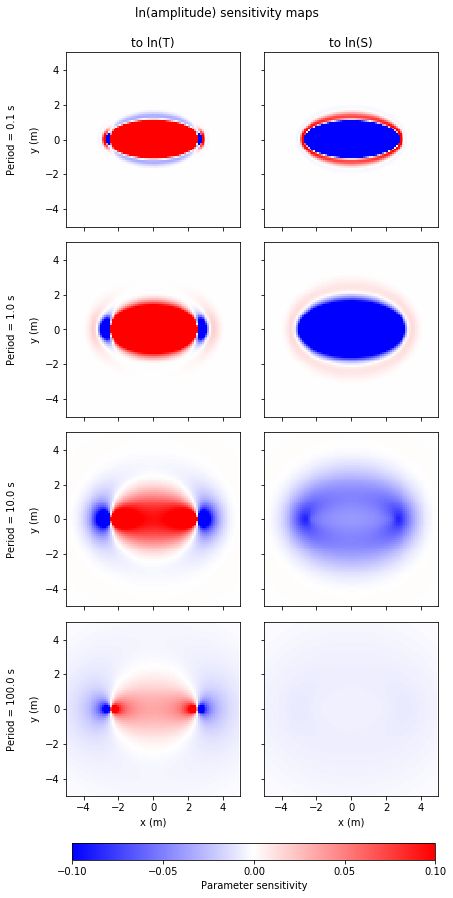

In [2]:
f = plt.figure(figsize=[16.00/2.54, 32.00/2.54])
f.suptitle('ln(amplitude) sensitivity maps')
s = np.reshape([f.add_subplot(4, 2, sp) for sp in range(1,9)], [4,2])
 
for p in range(num_periods):    
    (xg, yg, logmag_logT_sens, logmag_logS_sens, phase_logT_sens, 
     phase_logS_sens) = oscill_sens_generator_linesrc(Qpeak, period_list[p], S, 
     T, domain_def, pump_loc, obs_loc)
       
    s[p,0].set_aspect('equal')
    s[p,0].pcolor(xg, yg, logmag_logT_sens, cmap='bwr', vmin=-0.1, vmax=0.1)
    s[p,0].set_xlim(domain_def[0,0], domain_def[0,2])
    s[p,0].set_ylim(domain_def[1,0], domain_def[1,2])
    
    s[p,1].set_aspect('equal')
    pl = s[p,1].pcolor(xg, yg, logmag_logS_sens, cmap='bwr', vmin=-0.1, vmax=0.1)
    s[p,1].set_xlim(domain_def[0,0], domain_def[0,2])
    s[p,1].set_ylim(domain_def[1,0], domain_def[1,2])
    
    if p==0:
        s[p,0].set_title('to ln(T)')
        s[p,1].set_title('to ln(S)')
    if p==num_periods-1:
        s[p,0].set_xlabel('x (m)')
        s[p,1].set_xlabel('x (m)')
    else:
        s[p,0].set_xticklabels([])
        s[p,1].set_xticklabels([])       
    s[p,0].set_ylabel('Period = '+str(period_list[p])+' s\n\ny (m)')
    s[p,1].set_yticklabels([])
    
mpl.colorbar.ColorbarBase(ax=f.add_axes([0.16, 0.04, 0.80, 0.018]),
                          cmap=plt.get_cmap('bwr'),
                          norm=mpl.colors.Normalize(vmin=-0.1, vmax=0.1),
                          ticks=np.arange(-0.1, 0.15, 0.05), 
                          orientation='horizontal',
                          label='Parameter sensitivity')

plt.tight_layout()
f.subplots_adjust(top=0.93, bottom=0.11)

## Plot sensitivity of signal phase to aquifer transmissivity and storativity parameters:

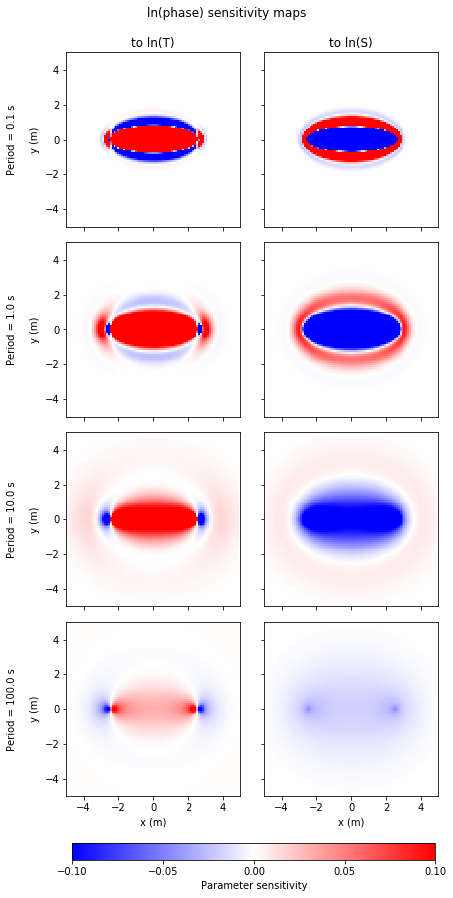

In [3]:
f = plt.figure(figsize=[16.00/2.54, 32.00/2.54])
f.suptitle('ln(phase) sensitivity maps')
s = np.reshape([f.add_subplot(4, 2, sp) for sp in range(1,9)], [4,2])

for p in range(num_periods):       
    (xg, yg, logmag_logT_sens, logmag_logS_sens, phase_logT_sens, 
     phase_logS_sens) = oscill_sens_generator_linesrc(Qpeak, period_list[p], S, 
     T, domain_def, pump_loc, obs_loc)

    s[p,0].set_aspect('equal')
    s[p,0].pcolor(xg, yg, phase_logT_sens, cmap='bwr', vmin=-0.1, vmax=0.1)
    s[p,0].set_xlim(domain_def[0,0], domain_def[0,2])
    s[p,0].set_ylim(domain_def[1,0], domain_def[1,2])
   
    s[p,1].set_aspect('equal')
    s[p,1].pcolor(xg, yg, phase_logS_sens, cmap='bwr', vmin=-0.1, vmax=0.1)
    s[p,1].set_xlim(domain_def[0,0], domain_def[0,2])
    s[p,1].set_ylim(domain_def[1,0], domain_def[1,2])

    if p==0:
        s[p,0].set_title('to ln(T)')
        s[p,1].set_title('to ln(S)')
    if p==num_periods-1:
        s[p,0].set_xlabel('x (m)')
        s[p,1].set_xlabel('x (m)')
    else:
        s[p,0].set_xticklabels([])
        s[p,1].set_xticklabels([])       
    s[p,0].set_ylabel('Period = '+str(period_list[p])+' s\n\ny (m)')
    s[p,1].set_yticklabels([])

mpl.colorbar.ColorbarBase(ax=f.add_axes([0.16, 0.04, 0.80, 0.018]),
                          cmap=plt.get_cmap('bwr'),
                          norm=mpl.colors.Normalize(vmin=-0.1, vmax=0.1),
                          ticks=np.arange(-0.1, 0.15, 0.05), 
                          orientation='horizontal',
                          label='Parameter sensitivity')

plt.tight_layout()
f.subplots_adjust(top=0.93, bottom=0.11)